**References:** 

https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c 

https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb


In [58]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.4.1


In [59]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [60]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0


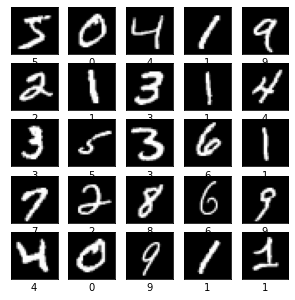

In [61]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(5,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [ ]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the digit classification model
history = model.fit(train_images, train_labels, epochs= 20)

Epoch 1/20
1875/1875 [==============================] - 141s 75ms/step - loss: 0.2913 - accuracy: 0.9100
Epoch 2/20
1875/1875 [==============================] - 140s 74ms/step - loss: 0.0565 - accuracy: 0.9830
Epoch 3/20
1875/1875 [==============================] - 139s 74ms/step - loss: 0.0366 - accuracy: 0.9886
Epoch 4/20
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0280 - accuracy: 0.9910
Epoch 5/20
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0226 - accuracy: 0.9929
Epoch 6/20
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0163 - accuracy: 0.9947
Epoch 7/20
 303/1875 [===>..........................] - ETA: 1:56 - loss: 0.0127 - accuracy: 0.9951

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [64]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test acc:', test_acc)

313/313 [==============================] - 6s 20ms/step - loss: 0.0624 - accuracy: 0.9888
Test acc: 0.9887999892234802


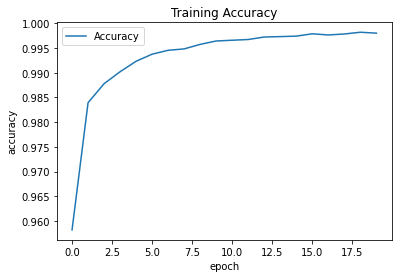

In [65]:
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

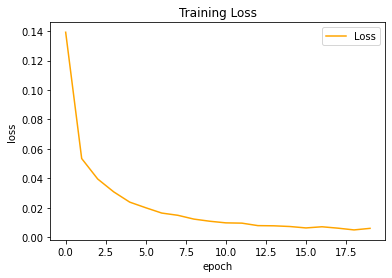

In [66]:
plt.plot(history.history['loss'], color='orange')
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss'], loc='upper right')
plt.show()

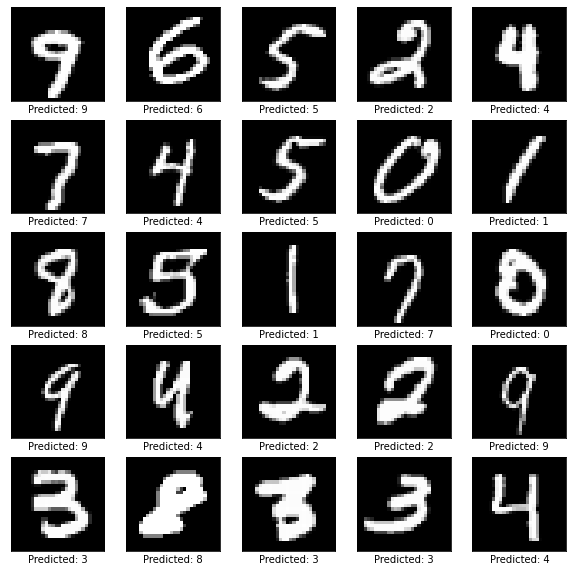

In [67]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(10, 10))
for i in range(25):
  ax = plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [68]:
#####################################################################
# Takes Keras model and converts it to TFL model for use on arduino #
#####################################################################

tflite_model_name = 'OCR_model'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbnxteo_y/assets


INFO:tensorflow:Assets written to: /tmp/tmpbnxteo_y/assets


117184

In [69]:
###################################################
# This section converts tflite model into C array #
###################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [70]:
###################################################
# Convert C array into .h file for use in arduino #
###################################################

# Write TFLite model to a C source (or header) file

c_model_name = 'OCR_model'

with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))